<a href="https://colab.research.google.com/github/jayeshraj619/AI-LAB/blob/master/lekshmi%20priya.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [58]:
# Importing the required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

In [207]:
# The function is defined with default parameters so that if you call it with just your data, it will construct a DataFrame with t-1 
# as X and t as y

def series_to_supervised(data, n_in = 1, n_out = 1, dropnan = True):
    n_vars = 1 if type(data) is list else data.shape[1]
    
    df = pd.DataFrame(data)
    cols, names = list(), list()
    
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
        
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
        
    return agg

In [208]:
df = pd.read_csv("/content/t.csv")
df

,month,spi1,sl1,avg R.HUM,avg temp
0,01-05-1980,-1.469306,-1.469306,0.856281,22.978145
1,01-06-1980,0.364798,-1.469306,0.942733,23.261097
2,01-07-1980,0.606144,0.364798,0.903878,24.600967
3,01-08-1980,0.606144,0.606144,0.882303,24.909726
4,01-09-1980,1.001410,0.606144,0.833859,23.641217
...,...,...,...,...,...
404,01-01-2014,0.317544,0.143235,0.682444,27.362823
405,01-02-2014,0.546507,0.317544,0.783198,23.614450
406,01-03-2014,0.629004,0.546507,0.946414,23.285097
407,01-04-2014,0.174373,0.629004,0.959161,24.194050


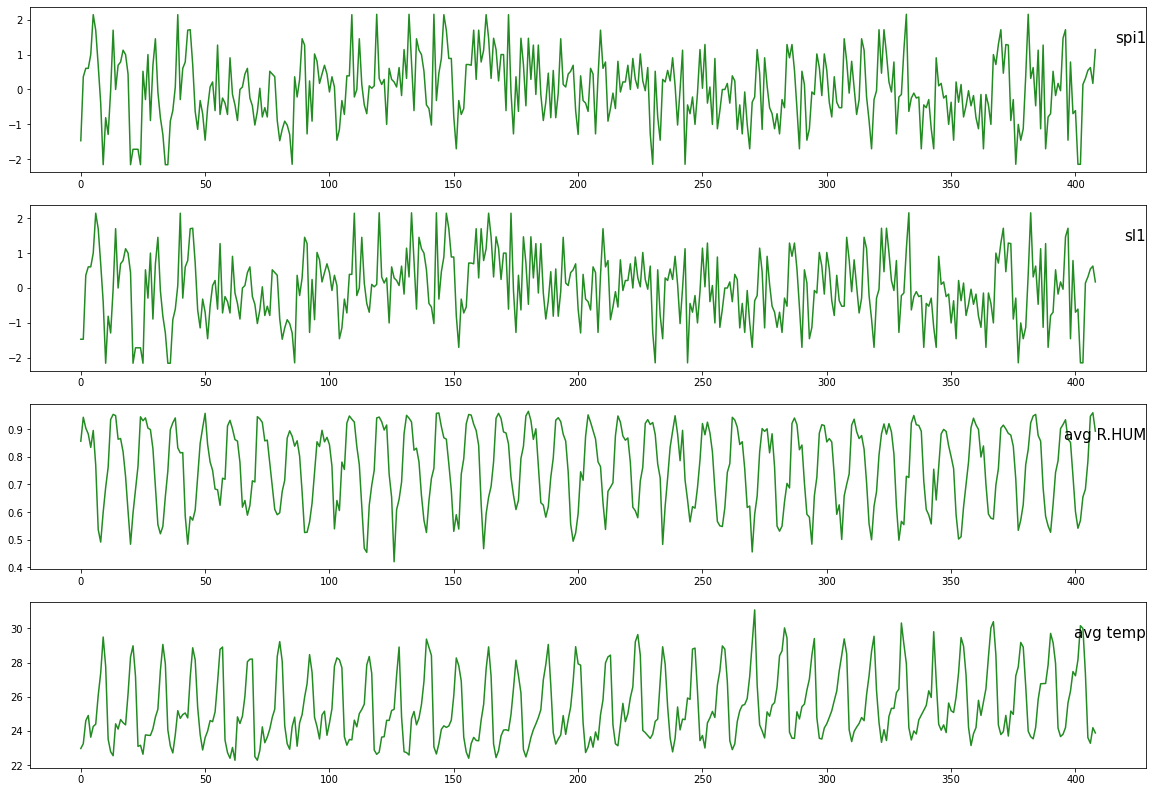

In [209]:
values = df.values

# specify columns to plot
groups = [1, 2, 3, 4]
i = 1

# plot each column
plt.figure(figsize=(20,14))
for group in groups:
    plt.subplot(len(groups), 1, i)
    plt.plot(values[:, group], c = "forestgreen")
    plt.title(df.columns[group], y=0.75, loc='right', fontsize = 15)
    i += 1
plt.show()

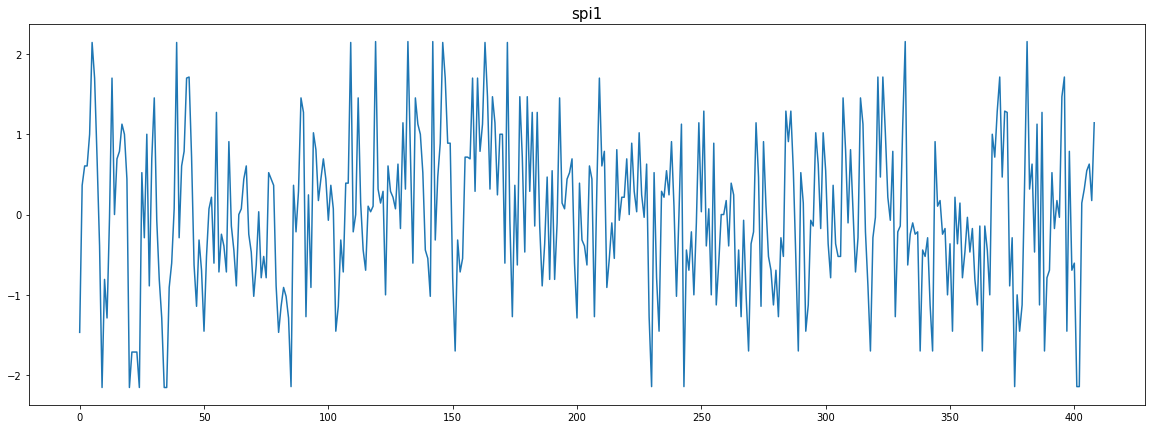

In [210]:
fig = plt.figure(figsize = (20,7))
plt.plot(df.spi1)
plt.title("spi1", fontsize = 15)
plt.show()

In [211]:
del df["month"]

In [212]:
from sklearn.metrics import mean_absolute_error , mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder

In [213]:
# Scaling the entire dataset

dataset = df
values = dataset.values

values = values.astype('float32')

scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
print(scaled.shape)

(409, 4)


In [214]:
# converting the dataset as supervised learning

reframed = series_to_supervised(scaled, 1, 1)
print(reframed.shape)

(408, 8)


In [215]:
print(reframed.head())

# Here, there are some unwanted data, which we don't want to predict, i.e here var2(t), var3(3), ....

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var1(t)   var2(t)   var3(t)  \
1   0.159405   0.159405   0.801607   0.078166  0.584563  0.159405  0.960588   
2   0.584563   0.159405   0.960588   0.110365  0.640508  0.584563  0.889136   
3   0.640508   0.584563   0.889136   0.262840  0.640508  0.640508  0.849461   
4   0.640508   0.640508   0.849461   0.297976  0.732133  0.640508  0.760374   
5   0.732133   0.640508   0.760374   0.153622  0.997405  0.732133  0.872728   

    var4(t)  
1  0.110365  
2  0.262840  
3  0.297976  
4  0.153622  
5  0.224777  


In [216]:
reframed.columns

Index(['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var1(t)',
       'var2(t)', 'var3(t)', 'var4(t)'],
      dtype='object')

In [217]:
# droping columns we don't want to predict

reframed.drop(reframed.columns[[5,6,7]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)   var1(t)
1   0.159405   0.159405   0.801607   0.078166  0.584563
2   0.584563   0.159405   0.960588   0.110365  0.640508
3   0.640508   0.584563   0.889136   0.262840  0.640508
4   0.640508   0.640508   0.849461   0.297976  0.732133
5   0.732133   0.640508   0.760374   0.153622  0.997405


In [218]:
values = reframed.values

# We train the model on the 1st 3 years and then test on the last year (for now)
n_train_hours = 286

train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

# reshape input to be 3D :- (no.of samples, no.of timesteps, no.of features)
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(286, 1, 4) (286,) (122, 1, 4) (122,)


In [219]:
train.shape, test.shape, values.shape

((286, 5), (122, 5), (408, 5))

In [229]:
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization,GRU
from tensorflow.keras.models import Sequential

In [230]:
model = Sequential()
model.add(GRU(64, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_split=0.2, verbose=2, shuffle=False)

Epoch 1/50
4/4 - 2s - loss: 0.2817 - val_loss: 0.1579 - 2s/epoch - 558ms/step
Epoch 2/50
4/4 - 0s - loss: 0.2030 - val_loss: 0.1076 - 32ms/epoch - 8ms/step
Epoch 3/50
4/4 - 0s - loss: 0.1410 - val_loss: 0.0721 - 44ms/epoch - 11ms/step
Epoch 4/50
4/4 - 0s - loss: 0.0953 - val_loss: 0.0506 - 27ms/epoch - 7ms/step
Epoch 5/50
4/4 - 0s - loss: 0.0650 - val_loss: 0.0415 - 43ms/epoch - 11ms/step
Epoch 6/50
4/4 - 0s - loss: 0.0485 - val_loss: 0.0418 - 24ms/epoch - 6ms/step
Epoch 7/50
4/4 - 0s - loss: 0.0424 - val_loss: 0.0473 - 26ms/epoch - 6ms/step
Epoch 8/50
4/4 - 0s - loss: 0.0425 - val_loss: 0.0534 - 46ms/epoch - 11ms/step
Epoch 9/50
4/4 - 0s - loss: 0.0446 - val_loss: 0.0569 - 25ms/epoch - 6ms/step
Epoch 10/50
4/4 - 0s - loss: 0.0458 - val_loss: 0.0570 - 25ms/epoch - 6ms/step
Epoch 11/50
4/4 - 0s - loss: 0.0453 - val_loss: 0.0547 - 24ms/epoch - 6ms/step
Epoch 12/50
4/4 - 0s - loss: 0.0438 - val_loss: 0.0515 - 25ms/epoch - 6ms/step
Epoch 13/50
4/4 - 0s - loss: 0.0424 - val_loss: 0.0488 - 2

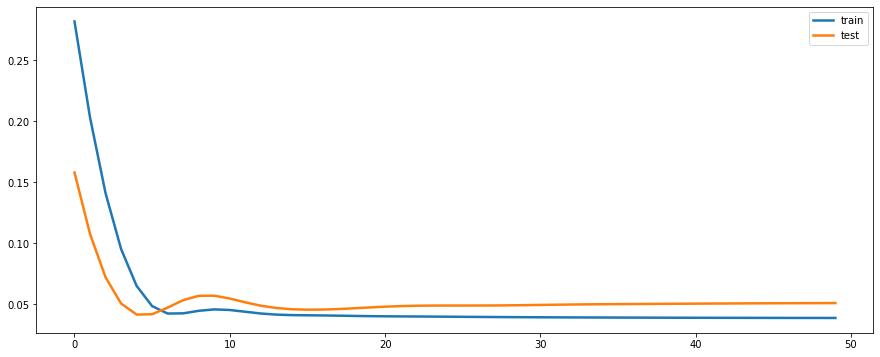

In [231]:
plt.figure(figsize=(15,6))
plt.plot(history.history['loss'], label='train', linewidth = 2.5)
plt.plot(history.history['val_loss'], label='test',  linewidth = 2.5)
plt.legend()
plt.show()

In [75]:
test_X.shape

(286, 1, 4)

In [232]:
testPredict = model.predict(test_X)
print(testPredict.shape)
testPredict = testPredict.ravel()

print(testPredict.shape)

(122, 1)
(122,)


In [123]:
test.shape

(286, 5)

In [ ]:
print(test), print(test.shape)

In [233]:
y_test_true = test[:,4]

In [225]:
testPredict.shape

(122,)

In [234]:
poll = np.array(df['spi1'])
print(poll.shape)
meanop = poll.mean()
stdop = poll.std()

y_test_true = y_test_true*stdop + meanop
testPredict = testPredict*stdop + meanop

testPredict.shape

(409,)


(122,)

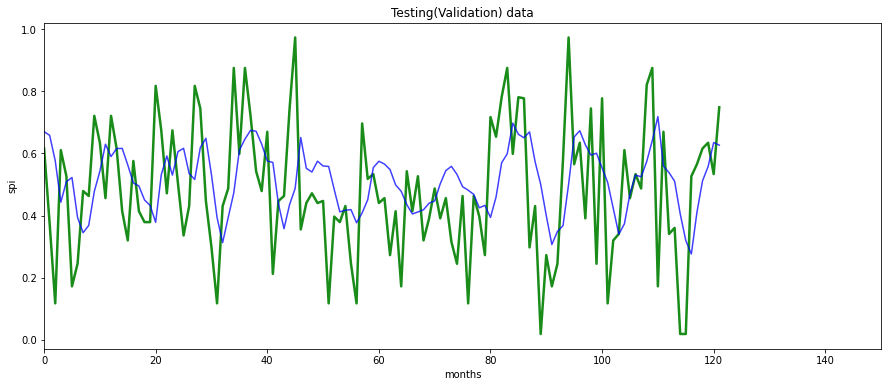

(122, 1)


ValueError: ignored

In [249]:
from matplotlib import pyplot as plt

plt.figure(figsize=(15,6))
plt.xlim([0,150])
plt.ylabel("spi")
plt.xlabel("months")

plt.plot(y_test_true, c = "g", alpha = 0.90, linewidth = 2.5)
plt.plot(testPredict, c = "b", alpha = 0.75)
plt.title("Testing(Validation) data")
plt.show()
testPredict=testPredict.reshape(-1,1)
print(testPredict.shape)
testTrue = scaler.inverse_transform(testPredict)

In [236]:
from sklearn.metrics import r2_score
r=r2_score(y_test_true, testPredict)
print("r2socre ="  ,r)
rmse = np.sqrt(mean_squared_error(y_test_true, testPredict))
print("Test(Validation) RMSE ="  ,rmse)

# As we see the,  RMSE for testing data is low, and visually as well, from the above plots, we can see that the basic model is able to
# predict the future values of pollution (in ppm) pretty well

r2socre = -0.01752216782278171
Test(Validation) RMSE = 0.21343313
